# This is to complete the tasks of filling the template from scratch

I will try to write as much as possible without any look in the template and my own code

I will go through these steps:

1. Getting the data ready
2. Making feature extracting model
3. Keep training until I beat the paper

And I will run it locally because google basically give you nothing

## Getting the data ready

1. Download the data
2. Preprocess the data

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from helper_functions import *

In [ ]:
print(tf.__version__)

2.5.0


### Download the data

Since the shit crashed I figured out a way to get the already downlaoded data again. The builer thing did the trick
https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder#as_dataset

In [ ]:
builder = tfds.image.Food101(data_dir='tensorflow_datasets')
builder.download_and_prepare()
builder

In [ ]:
(train_data, test_data) = builder.as_dataset(split=['train', 'validation'],
                                                      shuffle_files=True,
                                                      as_supervised=True)

In [ ]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             data_dir='tensorflow_datasets',
                                             split=['train', 'validation'],
                                             as_supervised=True,
                                             with_info=True,
                                             shuffle_files=True,
                                             download=False)
                                      

In [ ]:
train_data1 = train_data.take(1)
for image, label in train_data1:
  print(image.shape, label)

(512, 512, 3) tf.Tensor(97, shape=(), dtype=int64)


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    data_path='tensorflow_datasets\\food101\\2.0.0',
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=75750, num_shards

### Preprocess the data


In [ ]:
def preprocess_image(image, label, img_shape=224):

  image = tf.image.resize(images=image, size=[img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
# Use function to turn it into batches

train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle it again to be sure
train_data = train_data.shuffle(buffer_size=500).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing to test
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_data)

2368

In [ ]:
checkpoint_path = 'milestone_project_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Creating the feature extraction model

In [ ]:
# Start to build your model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


### Compile and fit

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_data,
                    epochs=3,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[create_tensorboard_callback('Tensorboards', 'Milestone_project1'), model_checkpoint])

Saving TensorBoard log files to: Tensorboards/Milestone_project1/20220121-154343
Epoch 1/3


C:\Users\robin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 502s 210ms/step - loss: 1.8219 - accuracy: 0.5588 - val_loss: 1.2430 - val_accuracy: 0.6745
Epoch 2/3
2368/2368 [==============================] - 499s 209ms/step - loss: 1.2941 - accuracy: 0.6661 - val_loss: 1.1269 - val_accuracy: 0.7044
Epoch 3/3
2368/2368 [==============================] - 496s 209ms/step - loss: 1.1432 - accuracy: 0.7026 - val_loss: 1.0919 - val_accuracy: 0.7079


In [ ]:
first_res = model.evaluate(test_data)
first_res

790/790 [==============================] - 124s 156ms/step - loss: 1.0949 - accuracy: 0.7070


[1.0948776006698608, 0.7069702744483948]

### Save model

In [ ]:
model.save('saved_models/milestone1')

C:\Users\robin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_models/milestone1\assets


INFO:tensorflow:Assets written to: saved_models/milestone1\assets


In [ ]:
class_names = ds_info.features['label'].names 
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Make layers trainable

In [ ]:
base_model.trainable = True

In [ ]:
for layer in base_model.layers[:-5]:
  layer.trainable = False


for layer in base_model.layers[230:]:
  print(layer.trainable)

False
False
True
True
True
True
True


### Recompile and fit the model

With lower learning rate 

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

history_fine_tuned = model.fit(train_data,
                               epochs=5,
                               validation_data=test_data,
                               validation_steps=int(0.15*len(test_data)),
                               callbacks=[create_tensorboard_callback('Tensorboards', 'Milestone_project1'), model_checkpoint])

Saving TensorBoard log files to: Tensorboards/Milestone_project1/20220121-172130
Epoch 1/5


C:\Users\robin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 443s 184ms/step - loss: 0.9584 - accuracy: 0.7477 - val_loss: 0.9905 - val_accuracy: 0.7312
Epoch 2/5
2368/2368 [==============================] - 492s 207ms/step - loss: 0.8294 - accuracy: 0.7814 - val_loss: 0.9745 - val_accuracy: 0.7315
Epoch 3/5
2368/2368 [==============================] - 512s 216ms/step - loss: 0.7380 - accuracy: 0.8050 - val_loss: 0.9701 - val_accuracy: 0.7341
Epoch 4/5
2368/2368 [==============================] - 520s 219ms/step - loss: 0.6601 - accuracy: 0.8276 - val_loss: 0.9523 - val_accuracy: 0.7415
Epoch 5/5
2368/2368 [==============================] - 680s 286ms/step - loss: 0.5939 - accuracy: 0.8459 - val_loss: 0.9511 - val_accuracy: 0.7471


In [ ]:
first_fine_tune_res = model.evaluate(test_data)

790/790 [==============================] - 163s 206ms/step - loss: 0.9618 - accuracy: 0.7413


In [ ]:
model.save('saved_models/milestone1_5layer_finetune')

C:\Users\robin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_models/milestone1_5layer_finetune\assets


INFO:tensorflow:Assets written to: saved_models/milestone1_5layer_finetune\assets


## New trial with loaded model

In [ ]:
loaded_model = tf.keras.models.load_model('saved_models/milestone1')

### Make more layers trainable

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
base_model.trainable = True

In [ ]:
for layer in model.layers[1].layers[220:]:
  print(layer.trainable, layer.name)

True block6d_add
True block7a_expand_conv
True block7a_expand_bn
True block7a_expand_activation
True block7a_dwconv
True block7a_bn
True block7a_activation
True block7a_se_squeeze
True block7a_se_reshape
True block7a_se_reduce
True block7a_se_expand
True block7a_se_excite
True block7a_project_conv
True block7a_project_bn
True top_conv
True top_bn
True top_activation


In [ ]:
loaded_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
loaded_model.trainable = True
for layer in loaded_model.layers[1].layers[:-100]:
  layer.trainable = False
  

In [ ]:
for layer in loaded_model.layers[1].layers[100:]:
  print(layer.trainable)

In [ ]:
loaded_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])

history_30_epoch = loaded_model.fit(train_data,
                                    epochs=5,
                                    validation_data=test_data,
                                    validation_steps=int(0.15*len(test_data)),
                                    callbacks=[
                                               create_tensorboard_callback('Tensorboards', 'Milestone_project1_big'),
                                               model_checkpoint,
                                               early_stopping_callback
                                    ],
                                    initial_epoch=3)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


ERROR:tensorflow:Failed to start profiler: Another profiler is running.


Saving TensorBoard log files to: Tensorboards/Milestone_project1_big/20220121-194012
Epoch 4/5
   1/2368 [..............................] - ETA: 13:44:16 - loss: 0.3520 - accuracy: 0.8438ERROR:tensorflow:Failed to start profiler: Another profiler is running.


ERROR:tensorflow:Failed to start profiler: Another profiler is running.


2368/2368 [==============================] - 2078s 869ms/step - loss: 0.1560 - accuracy: 0.9549 - val_loss: 1.0937 - val_accuracy: 0.7609
Epoch 5/5
2368/2368 [==============================] - 2273s 955ms/step - loss: 0.0801 - accuracy: 0.9759 - val_loss: 1.1725 - val_accuracy: 0.7601


In [ ]:
layer_100_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 677s 848ms/step - loss: 1.1916 - accuracy: 0.7569


In [ ]:
loaded_model.save('saved_models/2_more_epochs')

C:\Users\robin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_models/2_more epochs\assets


INFO:tensorflow:Assets written to: saved_models/2_more epochs\assets


### Section with runtime inside the notebook

Training was too slow, so I will upload a model I saved to this notbook and use it

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/TensforFlow_course/milestone1')

### Fixing training data etc for more training

In [3]:
import tensorflow_datasets as tfds

In [4]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete4EI74Y/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete4EI74Y/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
for layer in loaded_model.layers[1].layers:
  print(layer.trainable, layer.name)

True input_3
True rescaling_2
True normalization_2
True stem_conv_pad
True stem_conv
True stem_bn
True stem_activation
True block1a_dwconv
True block1a_bn
True block1a_activation
True block1a_se_squeeze
True block1a_se_reshape
True block1a_se_reduce
True block1a_se_expand
True block1a_se_excite
True block1a_project_conv
True block1a_project_bn
True block2a_expand_conv
True block2a_expand_bn
True block2a_expand_activation
True block2a_dwconv_pad
True block2a_dwconv
True block2a_bn
True block2a_activation
True block2a_se_squeeze
True block2a_se_reshape
True block2a_se_reduce
True block2a_se_expand
True block2a_se_excite
True block2a_project_conv
True block2a_project_bn
True block2b_expand_conv
True block2b_expand_bn
True block2b_expand_activation
True block2b_dwconv
True block2b_bn
True block2b_activation
True block2b_se_squeeze
True block2b_se_reshape
True block2b_se_reduce
True block2b_se_expand
True block2b_se_excite
True block2b_project_conv
True block2b_project_bn
True block2b_drop


In [13]:
def preprocess_image(image, label, img_shape=224):

  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [15]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
checkpoint_path = 'milestone1/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=0)

In [17]:
tensorb_callback = tf.keras.callbacks.TensorBoard(log_dir='Tensorboards')

In [18]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


### Fine tuning takes place

In [32]:
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_3 True <Policy "float32">
rescaling_2 True <Policy "float32">
normalization_2 True <Policy "float32">
stem_conv_pad True <Policy "float32">
stem_conv True <Policy "float32">
stem_bn True <Policy "float32">
stem_activation True <Policy "float32">
block1a_dwconv True <Policy "float32">
block1a_bn True <Policy "float32">
block1a_activation True <Policy "float32">
block1a_se_squeeze True <Policy "float32">
block1a_se_reshape True <Policy "float32">
block1a_se_reduce True <Policy "float32">
block1a_se_expand True <Policy "float32">
block1a_se_excite True <Policy "float32">
block1a_project_conv True <Policy "float32">
block1a_project_bn True <Policy "float32">
block2a_expand_conv True <Policy "float32">
block2a_expand_bn True <Policy "float32">
block2a_expand_activation True <Policy "float32">


In [22]:
earl_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=3)

In [27]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

In [31]:
for layer in model.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">


### Compile and fit first model with mixed precision

In [33]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
history = model.fit(train_data,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)))
model.save('/content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_5e')

Epoch 1/5
2368/2368 [==============================] - 188s 76ms/step - loss: 1.8205 - accuracy: 0.5576 - val_loss: 1.2241 - val_accuracy: 0.6790
Epoch 2/5
2368/2368 [==============================] - 179s 75ms/step - loss: 1.2925 - accuracy: 0.6672 - val_loss: 1.1250 - val_accuracy: 0.7002
Epoch 3/5
2368/2368 [==============================] - 178s 74ms/step - loss: 1.1425 - accuracy: 0.7019 - val_loss: 1.0900 - val_accuracy: 0.6976
Epoch 4/5
2368/2368 [==============================] - 175s 73ms/step - loss: 1.0442 - accuracy: 0.7265 - val_loss: 1.0711 - val_accuracy: 0.7116
Epoch 5/5
2368/2368 [==============================] - 177s 74ms/step - loss: 0.9722 - accuracy: 0.7442 - val_loss: 1.0674 - val_accuracy: 0.7124
INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_5e/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_5e/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [37]:
base_model.trainable = True
for layer in model.layers[1].layers[:10]:
  print(layer.trainable, layer.dtype_policy)

True <Policy "float32">
True <Policy "mixed_float16">
True <Policy "mixed_float16">
True <Policy "mixed_float16">
True <Policy "mixed_float16">
True <Policy "mixed_float16">
True <Policy "mixed_float16">
True <Policy "mixed_float16">
True <Policy "mixed_float16">
True <Policy "mixed_float16">


In [38]:
model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])

In [39]:
history_long = model.fit(train_data,
                                epochs=35,
                                validation_data=test_data,
                                validation_steps=int(0.15*len(test_data)),
                                callbacks=[tensorb_callback, model_checkpoint, earl_stop_callback],
                                initial_epoch=5)
model.save('/content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_35e')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 6/35
2368/2368 [==============================] - 346s 140ms/step - loss: 0.8496 - accuracy: 0.7691 - val_loss: 0.8390 - val_accuracy: 0.7696
Epoch 7/35
2368/2368 [==============================] - 330s 139ms/step - loss: 0.5215 - accuracy: 0.8546 - val_loss: 0.8347 - val_accuracy: 0.7770
Epoch 8/35
2368/2368 [==============================] - 332s 140ms/step - loss: 0.2910 - accuracy: 0.9169 - val_loss: 0.9260 - val_accuracy: 0.7677
Epoch 9/35
2368/2368 [==============================] - 333s 140ms/step - loss: 0.1585 - accuracy: 0.9522 - val_loss: 1.0429 - val_accuracy: 0.7680
Epoch 10/35
2368/2368 [==============================] - 329s 138ms/step - loss: 0.1024 - accuracy: 0.9683 - val_loss: 1.1622 - val_accuracy: 0.7624
INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_35e/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_35e/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [40]:
result = model.evaluate(test_data)
result

790/790 [==============================] - 48s 61ms/step - loss: 1.1601 - accuracy: 0.7613


[1.1601096391677856, 0.7613069415092468]

In [43]:
best_weight_model = model.load_weights('/content/milestone1/cp.ckpt')

In [45]:
best_weight_result = model.evaluate(test_data)
best_weight_result

790/790 [==============================] - 48s 61ms/step - loss: 0.8301 - accuracy: 0.7758


[0.8301093578338623, 0.775801956653595]

I have blinxed very on modelcheckpoint. We load the weights back into the model we are working with and then keep training from that point or evaluate it again. As above, it turned out to be good enough to beat the 77.4% from deep food paper. Done deal. Onwards to next taks

In [51]:
# Save the best model
model.save('/content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_35e_best_weight')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_35e_best_weight/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_35e_best_weight/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


tf.Tensor(
[ 1 48 20 68 32 69 35 55 83 43 89 97  4 60 78 22 17 10 93 88 14 68 13 55
 66 86 23 21 58 30  7 56], shape=(32,), dtype=int64)


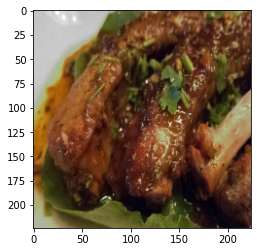

In [50]:
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
  plt.imshow(image[0]/255.)
  print(label)

In [52]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-01-24 09:46:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-24 09:46:16 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Make predictions and visualize

In [ ]:
from helper_functions import *

In [32]:
# We need to make some changes to our confusion matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [54]:
preds_probs = model.predict(test_data)

In [56]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3,  0])

In [57]:
len(pred_classes)

25250

### Test_data fix

The test data is shuffled so I can't use the methods I have used in the previous notebooks. Use datasetbuilder method from tensorflow to unshuffle the data. I might have to redownload the files actually and turn shuffle off

In [83]:
food101_builder = tfds.builder('food101', data_dir='/root/tensorflow_datasets')
food101_info = food101_builder.info

In [84]:
food101_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [85]:
food101_builder.download_and_prepare()
datasets = food101_builder.as_dataset()

In [87]:
train_dataset, test_dataset = datasets['train'], datasets['validation']

In [88]:
test_dataset

<PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

Lets try the same with this new datset

It did not work, just redownload everything and try from there. Check the solution first maybe.

In [98]:
(train_dataset, test_dataset), info = tfds.load(name='food101',
                                                split=['train', 'validation'],
                                                as_supervised=True,
                                                with_info=True)

In [100]:
info.features['label'].names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [101]:
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [102]:
y_labels_2 = []
for images, labels in test_dataset.unbatch():
  y_labels_2.append(labels.numpy())

y_labels_2[:10] 

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [78]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())


y_labels[:10]

[42, 57, 46, 69, 100, 38, 10, 86, 16, 83]

In [79]:
np.array(y_labels).shape

(25250,)

In [ ]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_labels_2, pred_classes)
score

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [8]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TensforFlow_course/Saved_models/milestone1_35e_best_weight')

In [9]:
import tensorflow_datasets as tfds

In [10]:
(train_data, test_data), info = tfds.load('food101',
                                          split=['train', 'validation'],
                                          as_supervised=True,
                                          with_info=True)

In [14]:
def pre_data(image, label, img_shape=224):

  image = tf.image.resize(image, [img_shape, img_shape])

  return tf.cast(image, tf.float32), label

In [15]:
train_data = train_data.map(pre_data, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(pre_data, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
class_names = info.features['label'].names 
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
preds_probs = model.predict(test_data)


In [20]:
preds_probs[0].argmax(), preds_probs.shape

(29, (25250, 101))

In [23]:
predicted_class = preds_probs.argmax(axis=1)
predicted_class[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3,  0])

In [28]:
y_labels = []
for image, label in test_data.unbatch():
  y_labels.append(label.numpy())

In [30]:
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [31]:
score = accuracy_score(y_true=y_labels, y_pred=predicted_class)
score

0.7755247524752475

In [34]:
import matplotlib.pyplot as plt
import itertools

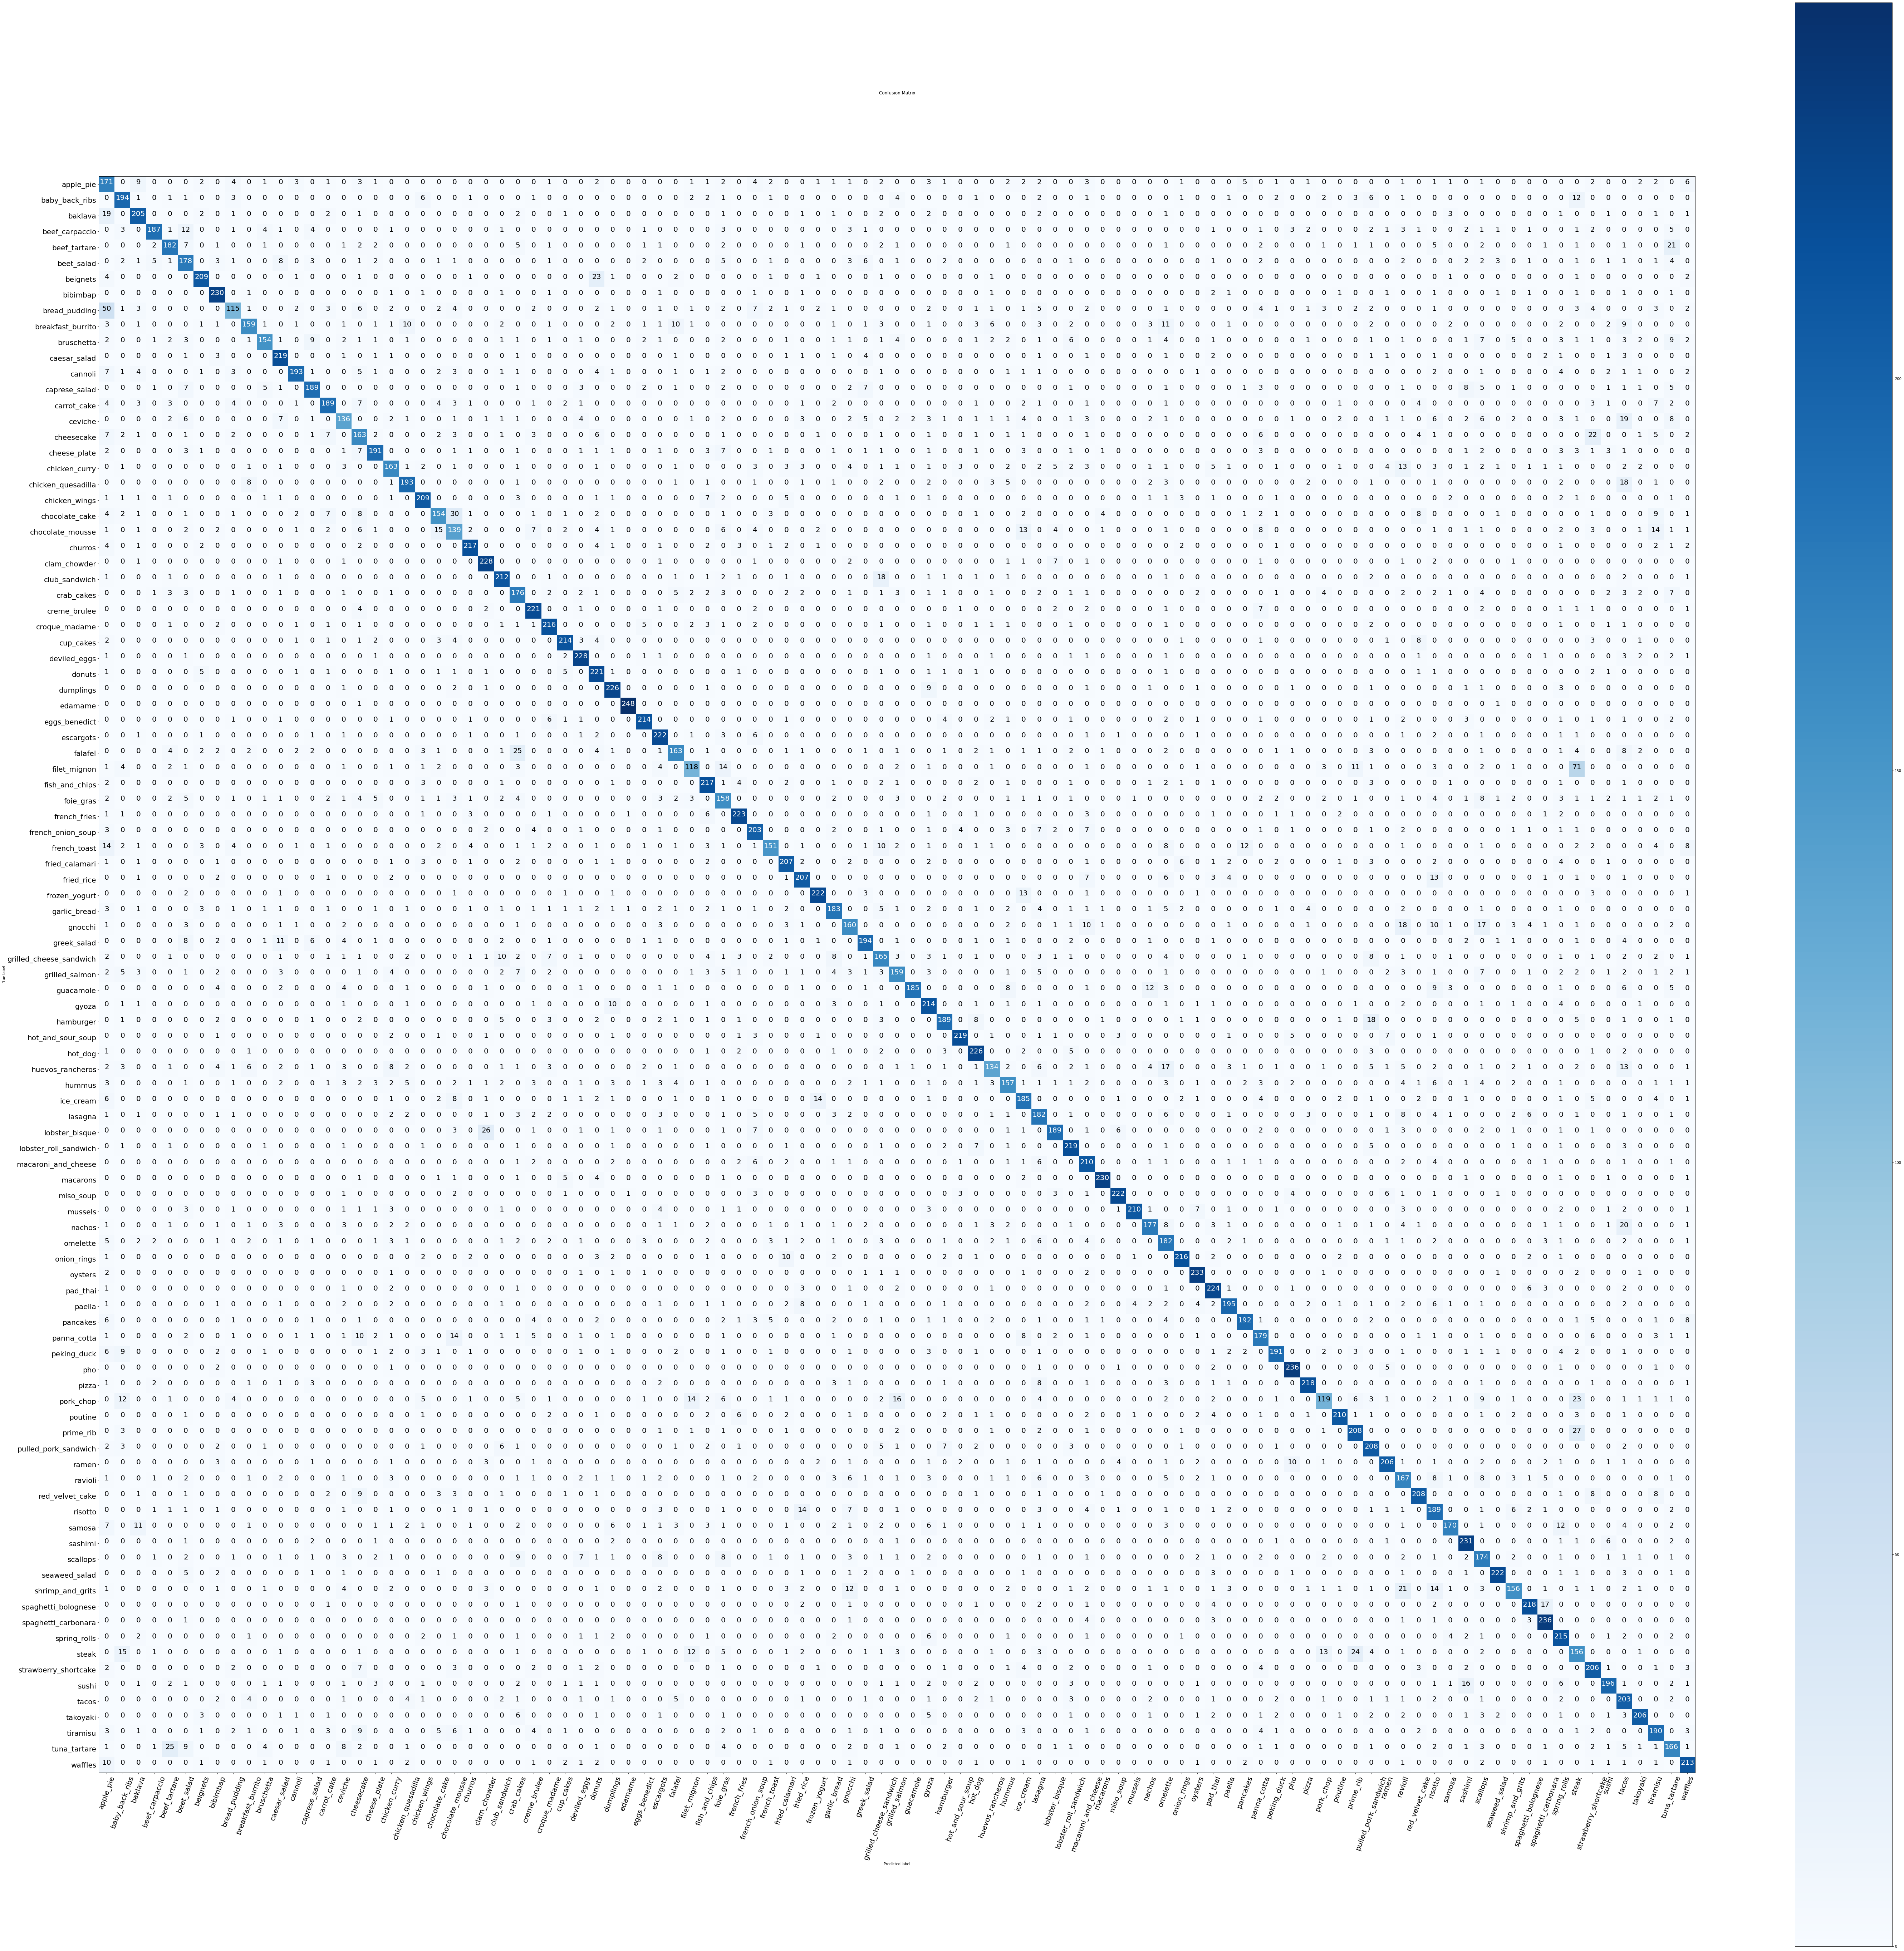

In [35]:
make_confusion_matrix(y_true=y_labels, 
                      y_pred=predicted_class,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

In [36]:
from sklearn.metrics import classification_report
classification_rep_dict = classification_report(y_labels, predicted_class, output_dict=True)

In [37]:
classification_rep_dict

{'0': {'f1-score': 0.5419968304278923,
  'precision': 0.44881889763779526,
  'recall': 0.684,
  'support': 250},
 '1': {'f1-score': 0.7504835589941973,
  'precision': 0.7265917602996255,
  'recall': 0.776,
  'support': 250},
 '10': {'f1-score': 0.7162790697674418,
  'precision': 0.8555555555555555,
  'recall': 0.616,
  'support': 250},
 '100': {'f1-score': 0.8145315487571702,
  'precision': 0.7802197802197802,
  'recall': 0.852,
  'support': 250},
 '11': {'f1-score': 0.8264150943396227,
  'precision': 0.7821428571428571,
  'recall': 0.876,
  'support': 250},
 '12': {'f1-score': 0.8318965517241379,
  'precision': 0.9018691588785047,
  'recall': 0.772,
  'support': 250},
 '13': {'f1-score': 0.7875,
  'precision': 0.8217391304347826,
  'recall': 0.756,
  'support': 250},
 '14': {'f1-score': 0.7891440501043842,
  'precision': 0.8253275109170306,
  'recall': 0.756,
  'support': 250},
 '15': {'f1-score': 0.6057906458797327,
  'precision': 0.6834170854271356,
  'recall': 0.544,
  'support': 2

In [38]:
class_f1_scores ={}

for k, v in classification_rep_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.5419968304278923,
 'baby_back_ribs': 0.7504835589941973,
 'baklava': 0.8023483365949119,
 'beef_carpaccio': 0.8201754385964913,
 'beef_tartare': 0.7443762781186093,
 'beet_salad': 0.6768060836501901,
 'beignets': 0.8583162217659137,
 'bibimbap': 0.8662900188323917,
 'bread_pudding': 0.5637254901960784,
 'breakfast_burrito': 0.7194570135746605,
 'bruschetta': 0.7162790697674418,
 'caesar_salad': 0.8264150943396227,
 'cannoli': 0.8318965517241379,
 'caprese_salad': 0.7875,
 'carrot_cake': 0.7891440501043842,
 'ceviche': 0.6057906458797327,
 'cheese_plate': 0.7974947807933194,
 'cheesecake': 0.6257197696737045,
 'chicken_curry': 0.6863157894736842,
 'chicken_quesadilla': 0.8008298755186722,
 'chicken_wings': 0.8393574297188756,
 'chocolate_cake': 0.6784140969162995,
 'chocolate_mousse': 0.5661914460285132,
 'churros': 0.8785425101214576,
 'clam_chowder': 0.8702290076335878,
 'club_sandwich': 0.8297455968688845,
 'crab_cakes': 0.6616541353383458,
 'creme_brulee': 0.85000000

In [40]:
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [41]:
f1_scores.head()

,class_names,f1-score
33,edamame,0.990020
63,macarons,0.934959
75,pho,0.912959
88,seaweed_salad,0.911704
54,hot_and_sour_soup,0.906832


In [42]:
def autolabel(scores):
  for score in scores:
    width = score.get_width()
   
    ax.text(1.05 * width, score.get_y() + (score.get_height() / 2.),
            '%d' % int(width),
            ha='center', va='top')

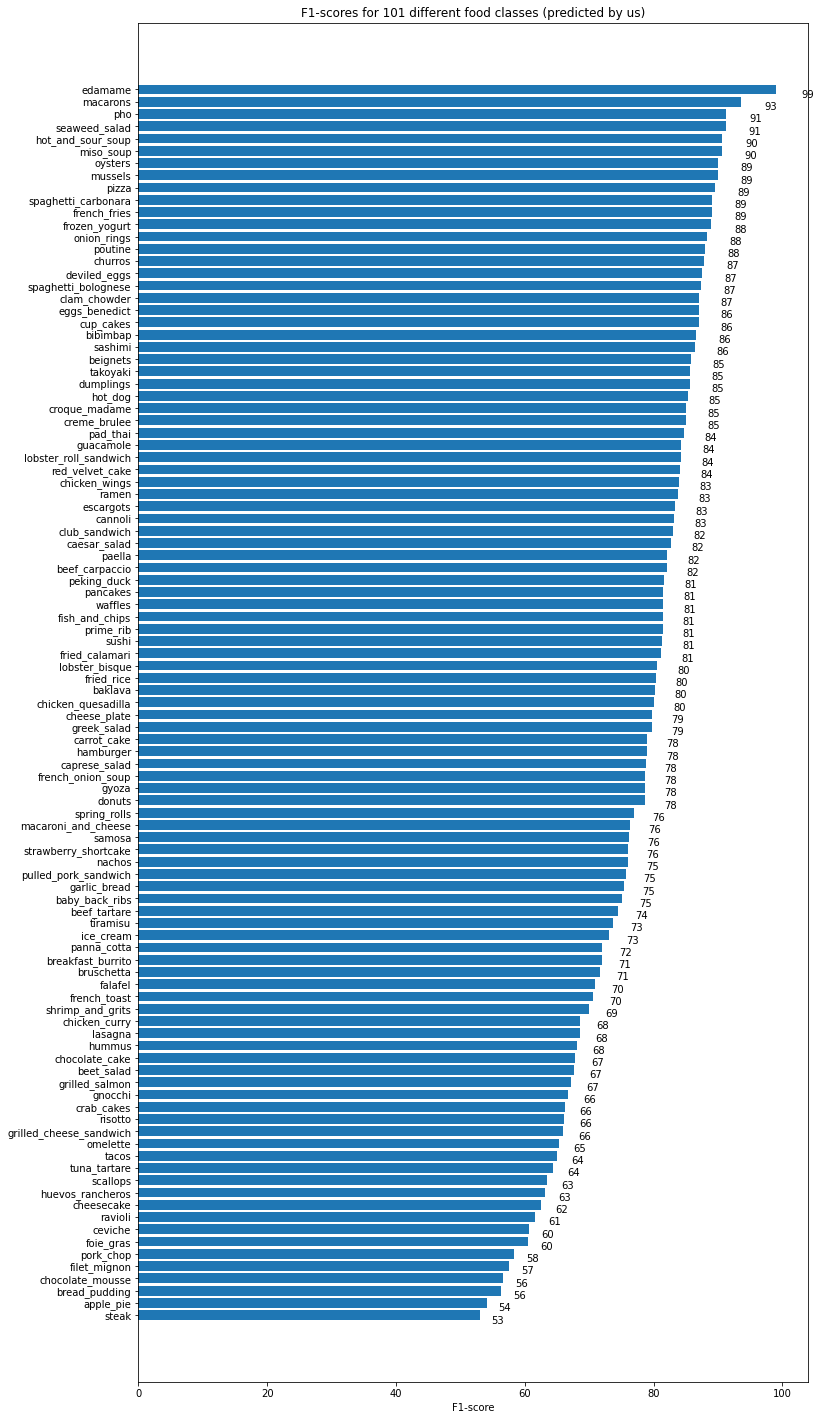

In [43]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values * 100)
autolabel(scores)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 different food classes (predicted by us)')
ax.invert_yaxis()


# Retraining with new base_model

In [46]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [44]:
train_data = train_data.shuffle(buffer_size=1000)

In [48]:
new_base_model = tf.keras.applications.EfficientNetB4(include_top=False)
new_base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

x = new_base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_E4 = tf.keras.Model(inputs, outputs)

In [ ]:
model_e4.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

history_E4 = model_E4.fit(train_data,
                          epochs=2,
                          validation_data=test_data,
                          validation_steps=int())

Oooopsie, looks like the runtime ran out and I cant use the GPU anymore. Soon the new computer will come.